Importing Required Libraries

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2023-05-09 21:33:41.924850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Limiting GPU Growth

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

Loading Images Into TensorFlow Pipeline

In [41]:
pics = tf.data.Dataset.list_files('/Users/hannaqasim/Desktop/Face Detection J/data/pictures/*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /Users/hannaqasim/Desktop/Face Detection J/data/pictures/*.jpg'

In [19]:
pics.as_numpy_iterator().next()

2023-05-09 15:52:02.367879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [122]
	 [[{{node Placeholder/_0}}]]
2023-05-09 15:52:02.368720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [122]
	 [[{{node Placeholder/_0}}]]


b'/Users/hannaqasim/Desktop/Face Detection J/data/pictures/e35df292-ecda-11ed-a551-acde48001122.jpg'

In [20]:
def load_pic(file_path):
    b_img = tf.io.read_file(file_path)
    l_img = tf.io.decode_jpeg(b_img)
    return l_img

In [21]:
pics = pics.map(load_pic)

In [22]:
pics.as_numpy_iterator().next()

2023-05-09 15:53:02.936811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [122]
	 [[{{node Placeholder/_0}}]]
2023-05-09 15:53:02.936998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [122]
	 [[{{node Placeholder/_0}}]]


array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [203, 196, 170],
        [203, 196, 170],
        [203, 196, 170]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [203, 196, 170],
        [203, 196, 170],
        [203, 196, 170]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [204, 197, 171],
        [204, 197, 171],
        [204, 197, 171]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [ 99,  40,  42],
        [ 99,  40,  42],
        [ 99,  40,  42]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [ 99,  40,  42],
        [100,  40,  42],
        [100,  40,  42]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [ 99,  40,  42],
        [100,  40,  42],
        [100,  40,  42]]

Distributing Data Amongst The Test, Train and Val Folders

-> Run image_distribution.py file

Creating an Augmented Dataset

In [6]:
import albumentations as A
import cv2 as cv
import os
import json
import numpy as np

In [4]:
# setting up augmentation pipeline using alb
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']))

In [27]:
# building and running the augmentation pipeline
# adpated from nicknochnack
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'pictures')):
        img = cv.imread(os.path.join('data', partition, 'pictures', image))
        
        if (isinstance(img, np.ndarray)):
            height, width, channel = img.shape
        else:
            None

        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            # updates the coords list with the respective coordinates of the label
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            # normalizes the coordinates by dividing each coordinate by its corresponding dimension of the image
            coords = list(np.divide(coords, [width, height, width, height]))

        try: 
            # performs data augmentation on the current image and its annotation each time.
            for x in range(40):
                transformed = transform(image=img, bboxes=[coords], class_labels=['face'])
                cv.imwrite(os.path.join('augmented_data', partition, 'pictures', f'{image.split(".")[0]}.{x}.jpg'), transformed['image'])
                
                # initializes an empty dictionary that will contain the annotation information for the augmented image.
                annotation = {}
                annotation['image'] = image

                # if label file exists so face most likely exists
                if os.path.exists(label_path):
                    # if no faces detected
                    if len(transformed['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                    # if face detected
                        annotation['bbox'] = transformed['bboxes'][0]
                        annotation['class'] = 1
                else: 
                # if no label file exists and so no faces in picture
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                with open(os.path.join('augmented_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
                    
        # if any error exists within the above code
        except Exception as e:
            None



Creating Final Dataset

In [14]:
# loading functions

# image loading loading function
def load_pic(file_path):
    b_img = tf.io.read_file(file_path)
    l_img = tf.io.decode_jpeg(b_img)
    return l_img

# label loading function
def load_labels(label_path):
    with open(label_path.numpy(), 'r') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [15]:
# loading anad preprocessing images
def load_and_preprocess_image(path):
    images = tf.data.Dataset.list_files(path, shuffle=False)
    images = images.map(load_pic)

    images = images.map(lambda x: (tf.image.resize(x, (150,150)))/255)
    return images

train_images = load_and_preprocess_image('/Users/hannaqasim/Desktop/Face Detection J/augmented_data/train/pictures/*.jpg')
test_images = load_and_preprocess_image('/Users/hannaqasim/Desktop/Face Detection J/augmented_data/test/pictures/*.jpg')
val_images = load_and_preprocess_image('/Users/hannaqasim/Desktop/Face Detection J/augmented_data/val/pictures/*.jpg')

train_images.as_numpy_iterator().next()

2023-05-09 21:34:43.444878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1760]
	 [[{{node Placeholder/_0}}]]


array([[[0.99215686, 0.9490196 , 0.8627451 ],
        [1.        , 0.95686275, 0.8784314 ],
        [0.99607843, 0.95686275, 0.8509804 ],
        ...,
        [0.84705883, 0.8       , 0.7058824 ],
        [0.84313726, 0.79607844, 0.7019608 ],
        [0.84705883, 0.8       , 0.7137255 ]],

       [[0.99607843, 0.9529412 , 0.8666667 ],
        [0.99215686, 0.9490196 , 0.87058824],
        [0.99215686, 0.94509804, 0.8509804 ],
        ...,
        [0.85490197, 0.80784315, 0.7137255 ],
        [0.84705883, 0.8       , 0.7058824 ],
        [0.84705883, 0.8       , 0.7137255 ]],

       [[1.        , 0.95686275, 0.87058824],
        [0.99607843, 0.94509804, 0.87058824],
        [0.99215686, 0.94509804, 0.8509804 ],
        ...,
        [0.85882354, 0.8117647 , 0.7254902 ],
        [0.85882354, 0.8117647 , 0.7254902 ],
        [0.8509804 , 0.8039216 , 0.7176471 ]],

       ...,

       [[0.22745098, 0.24705882, 0.25882354],
        [0.22352941, 0.23921569, 0.24313726],
        [0.22352941, 0

In [16]:
# load and preprocess labels
def load_and_preprocess_label(path):
    labels = tf.data.Dataset.list_files(path, shuffle=False)

    labels = labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
    return labels

train_labels = load_and_preprocess_label('/Users/hannaqasim/Desktop/Face Detection J/augmented_data/train/labels/*.json')
test_labels = load_and_preprocess_label('/Users/hannaqasim/Desktop/Face Detection J/augmented_data/test/labels/*.json')
val_labels = load_and_preprocess_label('/Users/hannaqasim/Desktop/Face Detection J/augmented_data/val/labels/*.json')

train_labels.as_numpy_iterator().next()

2023-05-09 21:34:46.753355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1760]
	 [[{{node Placeholder/_0}}]]


(array([1], dtype=uint8),
 array([0.    , 0.2183, 0.152 , 0.7773], dtype=float16))

In [17]:
# creating our final data set by combining images and labels

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [18]:
train.as_numpy_iterator().next()[1]

2023-05-09 21:34:51.959834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1760]
	 [[{{node Placeholder/_4}}]]
2023-05-09 21:34:51.960142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1760]
	 [[{{node Placeholder/_4}}]]


(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.767 , 0.8354, 1.    , 1.    ],
        [0.452 , 0.177 , 0.7515, 0.5205],
        [0.3994, 0.0639, 1.    , 1.    ],
        [0.    , 0.    , 0.34  , 0.4802],
        [0.    , 0.3455, 0.3547, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.876 , 0.3613, 1.    , 0.708 ]], dtype=float16))

Deep Learning Using Functional API And Creating A Neutral Network

In [19]:
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import load_model

In [20]:
# building my model

def build_model():
    # defining the input shape/layer of the images
    input_shape = (150, 150, 3)
    input_layer = Input(shape=input_shape)

    # adding convolutional layers to extract features from the input images
    conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # flatten the output from the convolutional layers
    flatten = Flatten()(pool3)
    # add a fully connected layer to classify the images
    class1 = Dense(64, activation='relu')(flatten)
    class2 = Dense(1, activation='sigmoid')(class1)

    # flatten the output from the convolutional layers
    flatten = Flatten()(pool3)
    # add a fully connected layer to classify the images
    regress1 = Dense(64, activation='relu')(flatten)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    # Create a model using the Model() function and specifying the input and output layers
    model = Model(inputs=input_layer, outputs=[class2, regress2])

    return model

Compiling The Model

In [21]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])

Training The Model Using The Fit() Method

In [22]:
x_train, y_train = train.as_numpy_iterator().next()
x_val, y_val = val.as_numpy_iterator().next()

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(x_train, y_train, batch_size=4, epochs=10, validation_data=(x_val, y_val), callbacks=[tensorboard_callback])

2023-05-09 21:35:04.459682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1240]
	 [[{{node Placeholder/_0}}]]
2023-05-09 21:35:04.459983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1240]
	 [[{{node Placeholder/_4}}]]


Epoch 1/10
2/2 [==============================] - 2s 397ms/step - loss: 2.1223 - dense_5_loss: 1.3823 - dense_7_loss: 0.7400 - dense_5_accuracy: 0.2500 - dense_5_mse: 0.4565 - dense_7_accuracy: 0.1250 - dense_7_mse: 0.2045 - val_loss: 1.7140 - val_dense_5_loss: 0.9987 - val_dense_7_loss: 0.7154 - val_dense_5_accuracy: 0.2500 - val_dense_5_mse: 0.3922 - val_dense_7_accuracy: 0.2500 - val_dense_7_mse: 0.1774
Epoch 2/10
2/2 [==============================] - 0s 183ms/step - loss: 1.3175 - dense_5_loss: 0.7145 - dense_7_loss: 0.6031 - dense_5_accuracy: 0.5000 - dense_5_mse: 0.2599 - dense_7_accuracy: 0.3750 - dense_7_mse: 0.1518 - val_loss: 1.3101 - val_dense_5_loss: 0.6490 - val_dense_7_loss: 0.6612 - val_dense_5_accuracy: 0.7500 - val_dense_5_mse: 0.2280 - val_dense_7_accuracy: 0.5000 - val_dense_7_mse: 0.1596
Epoch 3/10
2/2 [==============================] - 0s 178ms/step - loss: 1.2356 - dense_5_loss: 0.6887 - dense_7_loss: 0.5469 - dense_5_accuracy: 0.5000 - dense_5_mse: 0.2478 - dens

Making Predictions

In [23]:
test_data = test.as_numpy_iterator()

2023-05-09 21:35:13.441305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1320]
	 [[{{node Placeholder/_4}}]]
2023-05-09 21:35:13.441645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1320]
	 [[{{node Placeholder/_4}}]]


In [24]:
test_sample = test_data.next()

In [25]:
prediction = model.predict(test_sample[0])

1/1 [==============================] - 0s 127ms/step


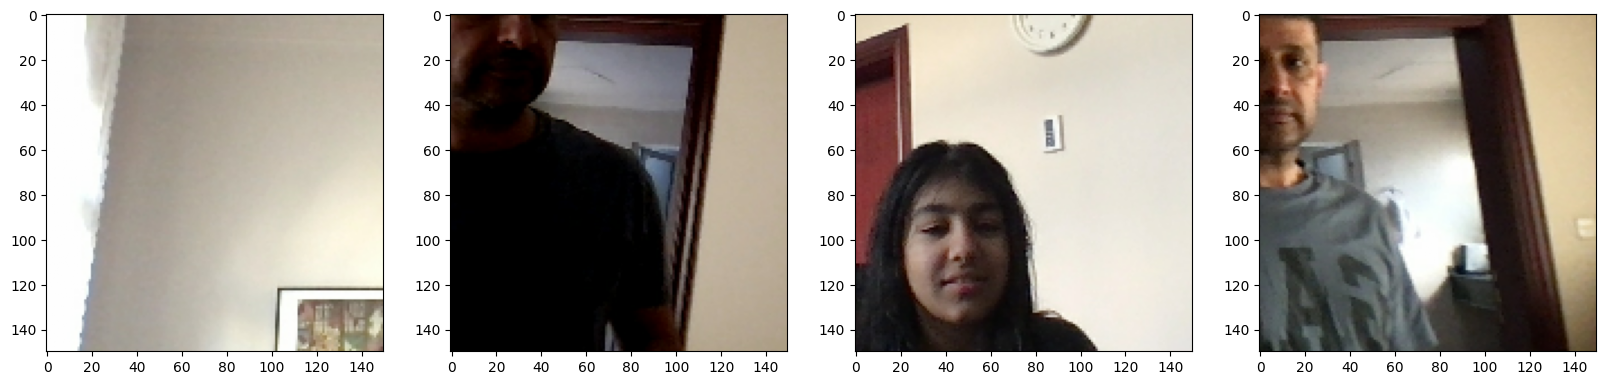

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = prediction[1][idx]
    
    if prediction[0][idx] > 0.9:
        cv.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

Saving Model

In [116]:
from tensorflow.keras.models import load_model

In [117]:
model.save('model.h5')
model = load_model('model.h5')

Final Thingy

In [118]:
# getting the video from laptop camera 
# later change to external video camera
cap = cv.VideoCapture(0)

while(True):
    # capture video frame by frame
    ret, frame = cap.read()

    # resizes frame size to 450x450
    resized_frame = cv.resize(frame, (450, 450))

    rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (150,150))

    yhat = model.predict(np.expand_dims(resized/255,0)) # no clue if this is right
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
    
    cv.imshow('EyeTrack', frame)

    # break out of the loop
    if cv.waitKey(20) & 0xFF == ord('q'):
        break

# when done with use - release video
cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 20ms/step
